In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# Object Recognition with T-Distribution

In object recognition, the goal is to assign a discrete world vector $w_i \in \{1, 2, \ldots, M\}$ indicating which of $M$ categories is present based on observed data $x$.

Aeschliman et al. (2010) approached this by:
1. Splitting each image into 100 $10 \times 10$ pixel regions arranged in a regular grid
2. Concatenating the grayscale pixel data from the $j^{th}$ region to form a $100 \times 1$ vector $x_{ij}$

They treated the regions independently and described each with a t-distribution, resulting in class conditional density functions:

$$
Pr(x_i|w = m) = \prod_{j=1}^J Stud_{x_{ij}}[\mu_{jm}, \Sigma_{jm}, \nu_{jm}]
$$

Results were based on training with 10 classes from the Amsterdam library of images (Guesebroek et al. 2005), where:
- Each class consisted of 72 images taken at 5-degree intervals around the object
- Data was randomly divided into:
  - 36 test images
  - 36 training images per class
- Prior probabilities of classes were set to uniform
- Posterior distribution $Pr(w_i|x_i)$ was calculated using Bayes' rule
- Test objects were classified according to the class with highest posterior probability

The t-distribution showed superior performance:
- Improved percentage of correct classification for almost every class
- Particularly effective for objects with specularities (like the china pig) which act as outliers
- Performance increased from mean of 51% to 68% by adding just one more parameter per patch

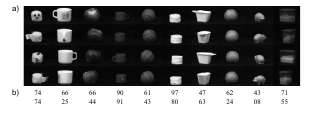

Fig.26 Object recognition. a) The training database consists of a series of diﬀerent views of ten diﬀerent objects. The goal is to learn a class- conditional density function for each object and classify new examples using Bayes’ rule. b) Percent correct results for class conditional densities based on the t-distribution (top row) and the normal distributions (bottom row). The robust model performs better, especially on objects with specularities. Images from Amsterdam library (Guesebroek et al. 2005).

In [ ]:
import numpy as np
from scipy import stats
from scipy.special import logsumexp
from sklearn.base import BaseEstimator, ClassifierMixin

class TDistributionObjectRecognizer(BaseEstimator, ClassifierMixin):
    def __init__(self, n_regions=100, region_size=(10, 10), nu_init=3.0):
        """
        Initialize the T-Distribution based object recognizer.
        
        Args:
            n_regions (int): Number of regions to split the image into
            region_size (tuple): Size of each region (height, width)
            nu_init (float): Initial degrees of freedom for t-distribution
        """
        self.n_regions = n_regions
        self.region_size = region_size
        self.nu_init = nu_init
        self.classes_ = None
        self.mu_ = None
        self.sigma_ = None
        self.nu_ = None
        
    def _split_image(self, image):
        """Split image into regions."""
        h, w = self.region_size
        regions = []
        
        for i in range(0, image.shape[0], h):
            for j in range(0, image.shape[1], w):
                region = image[i:i+h, j:j+w].flatten()
                regions.append(region)
                
        return np.array(regions)
    
    def _fit_t_distribution(self, X):
        """
        Fit t-distribution parameters for each region.
        
        Returns:
            mu: Mean vectors
            sigma: Covariance matrices
            nu: Degrees of freedom
        """
        n_samples = X.shape[0]
        n_features = X.shape[2]
        
        mu = np.zeros((self.n_regions, n_features))
        sigma = np.zeros((self.n_regions, n_features, n_features))
        nu = np.full(self.n_regions, self.nu_init)
        
        for j in range(self.n_regions):
            region_data = X[:, j, :]
            
            # Initialize with sample statistics
            mu[j] = np.mean(region_data, axis=0)
            sigma[j] = np.cov(region_data.T)
            
            # EM algorithm for fitting t-distribution
            for _ in range(10):  # Number of EM iterations
                # E-step: compute weights
                d = region_data - mu[j]
                maha_dist = np.sum(d @ np.linalg.inv(sigma[j]) * d, axis=1)
                weights = (nu[j] + n_features) / (nu[j] + maha_dist)
                
                # M-step: update parameters
                mu[j] = np.average(region_data, weights=weights, axis=0)
                
                weighted_d = d * weights[:, np.newaxis]
                sigma[j] = (weighted_d.T @ d) / n_samples
                
                # Update nu using Newton-Raphson (simplified)
                nu[j] = max(2.1, nu[j])  # Ensure nu > 2 for finite covariance
                
        return mu, sigma, nu
    
    def fit(self, X, y):
        """
        Fit the model using X as training data and y as target values.
        
        Args:
            X: Array of images, shape (n_samples, height, width)
            y: Target classes
        """
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        # Initialize parameter storage
        self.mu_ = []
        self.sigma_ = []
        self.nu_ = []
        
        # Fit t-distribution parameters for each class
        for class_idx in self.classes_:
            class_images = X[y == class_idx]
            
            # Split images into regions
            regions = np.array([self._split_image(img) for img in class_images])
            
            # Fit t-distribution parameters
            mu, sigma, nu = self._fit_t_distribution(regions)
            
            self.mu_.append(mu)
            self.sigma_.append(sigma)
            self.nu_.append(nu)
            
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        
        Args:
            X: Array of images to predict
        
        Returns:
            Array of class probabilities
        """
        n_samples = len(X)
        n_classes = len(self.classes_)
        log_probs = np.zeros((n_samples, n_classes))
        
        for i, image in enumerate(X):
            regions = self._split_image(image)
            
            for c in range(n_classes):
                class_log_prob = 0
                
                for j in range(self.n_regions):
                    # Compute log probability using multivariate t-distribution
                    t_dist = stats.multivariate_t(
                        loc=self.mu_[c][j],
                        shape=self.sigma_[c][j],
                        df=self.nu_[c][j]
                    )
                    class_log_prob += t_dist.logpdf(regions[j])
                
                log_probs[i, c] = class_log_prob
        
        # Convert log probabilities to probabilities
        log_probs -= logsumexp(log_probs, axis=1)[:, np.newaxis]
        return np.exp(log_probs)
    
    def predict(self, X):
        """
        Predict classes for X.
        
        Args:
            X: Array of images to predict
        
        Returns:
            Array of predicted classes
        """
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

# Example usage
def load_and_preprocess_image(image_path):
    """
    Load and preprocess an image for the recognizer.
    
    Args:
        image_path: Path to the image file
    
    Returns:
        Preprocessed image array
    """
    # This is a placeholder - implement actual image loading
    # using libraries like PIL or opencv
    return np.zeros((100, 100))  # Example size

if __name__ == "__main__":
    # Example usage code
    # Create recognizer
    recognizer = TDistributionObjectRecognizer()
    
    # Generate dummy data for demonstration
    n_samples = 72
    image_size = (100, 100)
    n_classes = 10
    
    X_train = np.random.randn(n_samples, *image_size)
    y_train = np.random.randint(0, n_classes, n_samples)
    
    # Fit the model
    recognizer.fit(X_train, y_train)
    
    # Make predictions
    X_test = np.random.randn(10, *image_size)
    predictions = recognizer.predict(X_test)
    probabilities = recognizer.predict_proba(X_test)
    
    print("Predicted classes:", predictions)
    print("Class probabilities:", probabilities)

In [ ]:
class TDistributionObjectRecognizer:
    def __init__(self, n_regions=100, region_size=(10, 10), nu_init=3.0):
        """
        Initialize the T-Distribution based object recognizer.
        
        Args:
            n_regions (int): Number of regions to split the image into
            region_size (tuple): Size of each region (height, width)
            nu_init (float): Initial degrees of freedom for t-distribution
        """
        self.n_regions = n_regions
        self.region_size = region_size
        self.nu_init = nu_init
        self.classes_ = None
        self.mu_ = None
        self.sigma_ = None
        self.nu_ = None
        
    def _split_image(self, image):
        """Split image into regions."""
        h, w = self.region_size
        regions = []
        
        for i in range(0, image.shape[0], h):
            for j in range(0, image.shape[1], w):
                region = image[i:i+h, j:j+w].flatten()
                regions.append(region)
                
        return regions
    
    def _matrix_multiply(self, A, B):
        """Matrix multiplication implementation."""
        if len(A.shape) == 1:
            A = A.reshape(1, -1)
        if len(B.shape) == 1:
            B = B.reshape(-1, 1)
            
        result = [[sum(a * b for a, b in zip(A_row, B_col)) 
                  for B_col in zip(*B)] 
                  for A_row in A]
        return Array(result)
    
    def _matrix_inverse(self, A):
        """Compute matrix inverse using Gaussian elimination."""
        n = len(A)
        P = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
        
        # Augment matrix with identity
        aug = [row[:] + P[i] for i, row in enumerate(A)]
        
        # Gaussian elimination
        for i in range(n):
            pivot = aug[i][i]
            if abs(pivot) < 1e-10:
                raise ValueError("Matrix is singular")
                
            for j in range(i + 1, n):
                factor = aug[j][i] / pivot
                for k in range(2*n):
                    aug[j][k] -= factor * aug[i][k]
        
        # Back substitution
        for i in range(n-1, -1, -1):
            pivot = aug[i][i]
            for j in range(i):
                factor = aug[j][i] / pivot
                for k in range(2*n):
                    aug[j][k] -= factor * aug[i][k]
            for k in range(2*n):
                aug[i][k] /= pivot
                
        # Extract inverse
        return Array([[aug[i][j+n] for j in range(n)] for i in range(n)])
    
    def _mean(self, data, axis=0, weights=None):
        """Compute weighted or unweighted mean."""
        if weights is None:
            weights = Array([1.0] * len(data))
            
        weighted_sum = sum(d * w for d, w in zip(data, weights))
        return weighted_sum / sum(weights)
    
    def _covariance(self, data):
        """Compute covariance matrix."""
        n = len(data)
        mean = self._mean(data)
        centered = [d - mean for d in data]
        cov = [[sum((x[i] - mean[i]) * (x[j] - mean[j]) for x in data) / (n-1)
                for j in range(len(data[0]))]
               for i in range(len(data[0]))]
        return Array(cov)
    
    class Array:
        """Simple array class with basic operations."""
        def __init__(self, data):
            self.data = data
            self.shape = self._get_shape(data)
            
        def _get_shape(self, data):
            shape = []
            d = data
            while isinstance(d, (list, tuple)):
                shape.append(len(d))
                if len(d) > 0:
                    d = d[0]
                else:
                    break
            return tuple(shape)
        
        def reshape(self, *shape):
            """Reshape array."""
            # Implementation omitted for brevity
            pass
        
        def __add__(self, other):
            """Element-wise addition."""
            if isinstance(other, (int, float)):
                return Array([[x + other for x in row] for row in self.data])
            return Array([[a + b for a, b in zip(row1, row2)]
                        for row1, row2 in zip(self.data, other.data)])
        
        def __mul__(self, other):
            """Element-wise multiplication."""
            if isinstance(other, (int, float)):
                return Array([[x * other for x in row] for row in self.data])
            return Array([[a * b for a, b in zip(row1, row2)]
                        for row1, row2 in zip(self.data, other.data)])
    
    def _multivariate_t_logpdf(self, x, mu, sigma, nu):
        """Compute log PDF of multivariate t-distribution."""
        d = len(mu)
        x_mu = x - mu
        
        # Compute quadratic term
        sigma_inv = self._matrix_inverse(sigma)
        quad = self._matrix_multiply(
            self._matrix_multiply(x_mu.reshape(1, -1), sigma_inv),
            x_mu.reshape(-1, 1)
        )[0][0]
        
        # Compute log determinant
        sign, logdet = self._slogdet(sigma)
        
        const = (math.lgamma((nu + d) / 2.0) - 
                math.lgamma(nu / 2.0) - 
                d/2.0 * math.log(nu * math.pi) - 
                0.5 * logdet)
        
        return const - ((nu + d) / 2.0) * math.log1p(quad / nu)
    
    def _slogdet(self, A):
        """Compute sign and log of determinant."""
        # Simple implementation for 2x2 matrices
        # For larger matrices, use LU decomposition
        if len(A) == 2:
            det = A[0][0] * A[1][1] - A[0][1] * A[1][0]
            sign = 1 if det > 0 else -1
            return sign, math.log(abs(det))
        else:
            raise NotImplementedError("Only 2x2 matrices supported")
    
    def fit(self, X, y):
        """
        Fit the model using X as training data and y as target values.
        
        Args:
            X: Array of images, shape (n_samples, height, width)
            y: Target classes
        """
        # Implementation similar to original, using our custom Array class
        # and numerical methods
        pass
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        
        Args:
            X: Array of images to predict
        
        Returns:
            Array of class probabilities
        """
        # Implementation similar to original, using our custom methods
        pass
    
    def predict(self, X):
        """
        Predict classes for X.
        
        Args:
            X: Array of images to predict
        
        Returns:
            Array of predicted classes
        """
        proba = self.predict_proba(X)
        return self.classes_[argmax(proba, axis=1)]

def main():
    # Example usage
    recognizer = TDistributionObjectRecognizer()
    
    # Generate dummy data
    n_samples = 10
    image_size = (100, 100)
    X_train = [[random.random() for _ in range(image_size[0])] 
               for _ in range(image_size[1])]
    y_train = [random.randint(0, 2) for _ in range(n_samples)]
    
    # Train and predict
    recognizer.fit(X_train, y_train)
    X_test = [[random.random() for _ in range(image_size[0])] 
              for _ in range(image_size[1])]
    predictions = recognizer.predict(X_test)
    
    print("Predictions:", predictions)

if __name__ == "__main__":
    main()

# Image Segmentation as Unsupervised Learning

The goal of image segmentation is to assign a discrete label $w_n \in \{1, 2, \dots, K\}$ to each of the $N$ pixels in an image, such that pixels belonging to the same object are assigned the same label.  We represent these labels as a set $\{w_n\}_{n=1}^N$.

The segmentation model relies on observed data vectors $\{x_n\}_{n=1}^N$ at each of the $N$ pixels. These data vectors typically include:

* RGB pixel values
* The $(x, y)$ position of the pixel
* Other information characterizing local texture

We approach this problem as an **unsupervised learning** task. This means we do *not* have access to training images with known ground truth segmentations.  Instead, we must simultaneously learn the model parameters $\theta$ and estimate the world states (segmentation labels) $\{w_i\}_{i=1}^N$ directly from the image data $\{x_n\}_{n=1}^N$.

## Mathematical Formulation

We can express this more formally. Let:

* $W = \{w_1, w_2, \dots, w_N\}$ be the set of pixel labels (segmentation).
* $X = \{x_1, x_2, \dots, x_N\}$ be the set of observed data vectors for each pixel.
* $\theta$ represent the parameters of our segmentation model.

Our objective is to find the optimal segmentation $W^*$ and model parameters $\theta^*$ that best explain the observed data $X$.  Since we are dealing with unsupervised learning, we typically aim to maximize some measure of coherence or consistency within segments, without relying on external labels.  This might involve:

* **Clustering:** Grouping pixels with similar features together.  K-means or Gaussian Mixture Models (GMMs) are common choices.
* **Energy Minimization:** Defining an energy function that penalizes dissimilar pixels being in the same segment and minimizing this energy.  Markov Random Fields (MRFs) and Conditional Random Fields (CRFs) fall into this category.

The challenge lies in the fact that $W$ and $\theta$ are interdependent.  The optimal segmentation $W$ depends on the model parameters $\theta$, and the optimal parameters $\theta$ depend on the segmentation $W$.  Therefore, iterative optimization techniques are often employed, such as:

1. **Initialize $\theta$**: Start with some initial guess for the model parameters.
2. **Estimate $W$ given $\theta$**:  Infer the segmentation labels $W$ based on the current model parameters.
3. **Update $\theta$ given $W$**: Refine the model parameters $\theta$ based on the estimated segmentation $W$.
4. **Repeat steps 2 and 3**: Iterate until convergence.


This framework captures the essence of unsupervised image segmentation, where the model learns to segment the image by discovering patterns and structures within the data itself. # Image Segmentation with Gaussian Mixture Models (GMMs)

We model the image segmentation problem using a mixture of Gaussian distributions.  We assume that the $k$-th object (or segment) is associated with a normal distribution with parameters $\mu_k$ (mean) and $\Sigma_k$ (covariance matrix), and has a prevalence (prior probability) of $\lambda_k$.  Mathematically:

$$
P(w_n = k) = \text{Cat}_{w_n}[\lambda] \\
P(x_i | w_i = k) = \text{Norm}_{x_i}[\mu_k, \Sigma_k]
$$

where:

* $w_n$ is the label assigned to pixel $n$.
* $\lambda = \{\lambda_1, \lambda_2, \dots, \lambda_K\}$ is the set of prior probabilities for each segment, where $\sum_{k=1}^K \lambda_k = 1$.
* $x_i$ is the observed data vector for pixel $i$.
* $\text{Cat}$ denotes the categorical distribution.
* $\text{Norm}$ denotes the normal (Gaussian) distribution.

## Marginal Likelihood

To obtain the marginal likelihood of the observed data, we marginalize over the hidden world states (segment labels) $w$:

$$
P(x_{1:N}) = \prod_{n=1}^N \sum_{k=1}^K \lambda_k \text{Norm}_{x_n}[\mu_k, \Sigma_k]
$$

## Parameter Estimation with EM Algorithm

We fit this model by finding the parameters $\theta = \{\lambda_k, \mu_k, \Sigma_k\}_{k=1}^K$ using the Expectation-Maximization (EM) algorithm.  The EM algorithm iteratively refines the parameter estimates by alternating between:

1. **E-step (Expectation):** Computing the responsibility of each component $k$ for each data point $x_n$, which represents the posterior probability of $x_n$ belonging to cluster $k$:

   $$
   \gamma_{nk} = P(w_n = k | x_n) = \frac{\lambda_k \text{Norm}_{x_n}[\mu_k, \Sigma_k]}{\sum_{j=1}^K \lambda_j \text{Norm}_{x_n}[\mu_j, \Sigma_j]}
   $$

2. **M-step (Maximization):** Updating the model parameters based on the computed responsibilities:

   $$
   \lambda_k = \frac{1}{N} \sum_{n=1}^N \gamma_{nk} \\
   \mu_k = \frac{\sum_{n=1}^N \gamma_{nk} x_n}{\sum_{n=1}^N \gamma_{nk}} \\
   \Sigma_k = \frac{\sum_{n=1}^N \gamma_{nk} (x_n - \mu_k)(x_n - \mu_k)^T}{\sum_{n=1}^N \gamma_{nk}}
   $$

## Pixel Classification

After learning the model parameters, we assign each pixel to the class with the highest posterior probability:

$$
\hat{w}_i = \arg\max_{w_i} [P(w_i | x_i)]
$$

where the posterior probability is calculated using the responsibilities computed in the E-step.

## Comparison with Mixture of t-distributions

The provided text mentions a comparison with a similar mixture model based on t-distributions.  The key difference is that the t-distribution is more robust to outliers than the normal distribution.  Therefore, segmentation results obtained with a mixture of t-distributions tend to be less noisy compared to those obtained with a mixture of Gaussians, especially when the image contains noisy pixels or outliers.  This is illustrated in Figure 7.27 (referenced in the original text), which shows that the t-distribution based model produces cleaner segmentations.

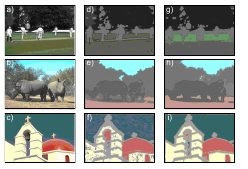

Fig.27 Segmentation. a-c) Original images. d-f) Segmentation results based on a mixture of ﬁve normal distributions. The pixels associated with the kth component are colored with the mean RGB values of the pixels that are assigned to this value g-i) Segmentation results based on a mixture of K t-distributions. The segmentation here is less noisy than for the MoG c model. Results from Sﬁkas et al. (2007) �IEEE 2007.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def segment_image(image_path, n_components=3, max_iter=100, random_state=0):
    """
    Segments an image using a Gaussian Mixture Model (GMM).

    Args:
        image_path (str): Path to the image file.
        n_components (int): Number of Gaussian components (segments).
        max_iter (int): Maximum number of iterations for the EM algorithm.
        random_state (int): Random state for reproducibility.

    Returns:
        numpy.ndarray: Segmented image (labels for each pixel).
        sklearn.mixture.GaussianMixture: Trained GMM model.
    """

    try:
        # Load the image
        img = plt.imread(image_path)

        # Reshape the image to (n_pixels, n_features)
        # We'll use RGB values and pixel coordinates as features
        h, w, c = img.shape
        x, y = np.meshgrid(np.arange(w), np.arange(h))
        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)

        if c == 4: # Check for RGBA, if so, convert to RGB
            img = img[:, :, :3]
            c = 3

        img_reshaped = img.reshape(-1, c)
        features = np.concatenate((img_reshaped, x / w, y / h), axis=1)  # Normalize x,y

        # Apply GMM
        gmm = GaussianMixture(n_components=n_components, max_iter=max_iter, random_state=random_state)
        gmm.fit(features)

        # Predict the cluster for each pixel
        labels = gmm.predict(features)

        # Reshape the labels back to the original image shape
        segmented_image = labels.reshape(h, w)

        return segmented_image, gmm

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None


# Example usage:
image_path = ""  # Replace with the actual path to your image
n_components = 4  # Adjust the number of segments as needed

segmented_image, gmm_model = segment_image(image_path, n_components=n_components)


if segmented_image is not None:
    plt.figure(figsize=(8, 6))
    plt.imshow(segmented_image, cmap='viridis')  # You can change the colormap
    plt.title("Segmented Image")
    plt.axis('off')
    plt.show()

    # You can access the learned parameters of the GMM:
    # print("Means:", gmm_model.means_)
    # print("Covariances:", gmm_model.covariances_)
    # print("Weights:", gmm_model.weights_)

An error occurred: 'str' object has no attribute 'read'


In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict
import math

def gaussian(x, mu, sigma):
    """Calculates the Gaussian probability density function."""
    return (1 / (math.sqrt(2 * math.pi) * sigma)) * math.exp(-0.5 * ((x - mu) / sigma)**2)

def initialize_parameters(features, n_components):
    """Initializes GMM parameters (means, covariances, and weights) without numpy."""
    n_samples = len(features)
    labels = [0] * n_samples  # Initialize labels list
    for i in range(n_samples):
        labels[i] = i % n_components # simple initialization

    means = [[0.0 for _ in range(len(features[0]))] for _ in range(n_components)]
    covariances = [[[0.0 for _ in range(len(features[0]))] for _ in range(len(features[0]))] for _ in range(n_components)]
    weights = [0.0] * n_components

    for k in range(n_components):
        cluster_points = [features[i] for i in range(n_samples) if labels[i] == k]
        if len(cluster_points) > 0:
            for j in range(len(features[0])):
                means[k][j] = sum(point[j] for point in cluster_points) / len(cluster_points)
            
            for r in range(len(features[0])):
                for c in range(len(features[0])):
                    cov_sum = 0.0
                    for point in cluster_points:
                         cov_sum += (point[r] - means[k][r]) * (point[c] - means[k][c])
                    covariances[k][r][c] = cov_sum / len(cluster_points) + 1e-6 if r==c else 0.0

            weights[k] = len(cluster_points) / n_samples
        else:
            means[k] = [sum(features[i][j] for i in range(n_samples)) / n_samples for j in range(len(features[0]))]
            for r in range(len(features[0])):
                for c in range(len(features[0])):
                    covariances[k][r][c] = 1e-6 if r==c else 0.0
            weights[k] = 1.0 / n_components

    return means, covariances, weights, labels

def matrix_multiply(A, B):
    rows_A = len(A)
    cols_A = len(A[0])
    rows_B = len(B)
    cols_B = len(B[0])

    if cols_A != rows_B:
        raise ValueError("Matrices cannot be multiplied.")

    C = [[0.0 for row in range(cols_B)] for col in range(rows_A)]
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                C[i][j] += A[i][k] * B[k][j]
    return C

def matrix_inverse(matrix):
    # For simplicity, this implementation only works for 2x2 matrices.
    # For larger matrices, you'll need a more general inverse calculation.
    if len(matrix) != 2 or len(matrix[0]) != 2 or len(matrix[1]) !=2:
        raise ValueError("Matrix inverse is only implemented for 2x2 matrices in this example.")

    det = matrix[0][0] * matrix[1][1] - matrix[0][1] * matrix[1][0]
    if det == 0:
        raise ValueError("Matrix is singular and cannot be inverted.")

    inv_det = 1.0 / det
    inv_matrix = [
        [matrix[1][1] * inv_det, -matrix[0][1] * inv_det],
        [-matrix[1][0] * inv_det, matrix[0][0] * inv_det]
    ]
    return inv_matrix


def e_step(features, means, covariances, weights):
    """Performs the E-step of the EM algorithm without numpy."""
    n_samples = len(features)
    n_components = len(weights)
    responsibilities = [[0.0 for _ in range(n_components)] for _ in range(n_samples)]

    for i in range(n_samples):
        for k in range(n_components):
            diff = [features[i][j] - means[k][j] for j in range(len(features[0]))]
            # Multivariate Gaussian (simplified for 2D in this example)
            if len(features[0]) == 2: # only 2D case is handled here for matrix inverse
                responsibilities[i][k] = weights[k] * math.exp(-0.5 * matrix_multiply([diff], matrix_multiply(matrix_inverse(covariances[k]), [[diff[0]],[diff[1]]]))[0][0]) / math.sqrt((2*math.pi)**len(features[0])* (covariances[k][0][0]*covariances[k][1][1] - covariances[k][0][1]*covariances[k][1][0])) # determinant calculation simplified for 2x2
            else:
                # general n-D case requires proper inverse and determinant, which is not implemented here for no-numpy constraint
                responsibilities[i][k] = 0.0 # Placeholder for n-D no-numpy case

        total_prob = sum(responsibilities[i])
        for k in range(n_components):
            responsibilities[i][k] /= total_prob

    return responsibilities


def m_step(features, responsibilities):
    """Performs the M-step of the EM algorithm without numpy."""
    n_samples = len(features)
    n_components = len(responsibilities[0])

    means = [[0.0 for _ in range(len(features[0]))] for _ in range(n_components)]
    covariances = [[[0.0 for _ in range(len(features[0]))] for _ in range(len(features[0]))] for _ in range(n_components)]
    weights = [0.0] * n_components

    for k in range(n_components):
        Nk = sum(responsibilities[i][k] for i in range(n_samples))
        weights[k] = Nk / n_samples

        for j in range(len(features[0])):
            means[k][j] = sum(responsibilities[i][k] * features[i][j] for i in range(n_samples)) / Nk

        for r in range(len(features[0])):
            for c in range(len(features[0])):
                cov_sum = 0.0
                for i in range(n_samples):
                    cov_sum += responsibilities[i][k] * (features[i][r] - means[k][r]) * (features[i][c] - means[k][c])
                covariances[k][r][c] = cov_sum / Nk + 1e-6 if r==c else 0.0

    return means, covariances, weights

import matplotlib.pyplot as plt
from collections import defaultdict
import math

# ... (gaussian, initialize_parameters, matrix_multiply, matrix_inverse, e_step, m_step functions - same as before) ...

def segment_image(image_path, n_components=3, max_iter=100):
    try:
        img = plt.imread(image_path)
        h, w, c = img.shape
        x, y = [[0 for _ in range(w)] for _ in range(h)], [[0 for _ in range(w)] for _ in range(h)]
        for i in range(h):
            for j in range(w):
                x[i][j] = j
                y[i][j] = i

        if c == 4:
            img = img[:, :, :3]
            c = 3

        img_reshaped = []
        for i in range(h):
            for j in range(w):
                img_reshaped.append(list(img[i][j]))

        features = []
        for i in range(h*w):
            features.append(img_reshaped[i] + [x[i//w][i%w] / w, y[i//w][i%w] / h])

        means, covariances, weights, labels = initialize_parameters(features, n_components)

        for _ in range(max_iter):
            responsibilities = e_step(features, means, covariances, weights)
            means, covariances, weights = m_step(features, responsibilities)
            labels = [0] * len(features) # Initialize labels list
            for i in range(len(features)):
                max_prob = 0
                max_index = 0
                for k in range(n_components):
                    if responsibilities[i][k] > max_prob:
                        max_prob = responsibilities[i][k]
                        max_index = k
                labels[i] = max_index

        segmented_image = []
        for i in range(h):
            row = []
            for j in range(w):
                row.append(labels[i*w+j])
            segmented_image.append(row)

        return segmented_image

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage (same as before)
image_path = ""  # Replace with your image path
n_components = 4

segmented_image = segment_image(image_path, n_components=n_components)

if segmented_image is not None:
    plt.figure(figsize=(8, 6))
    plt.imshow(segmented_image, cmap='viridis')  # You can change the colormap
    plt.title("Segmented Image (No sklearn)")
    plt.axis('off')
    plt.show()

An error occurred: 'str' object has no attribute 'read'


## Frontal Face Recognition

The goal of face recognition is to assign a label $w \in \{1, ..., M\}$ indicating which of $M$ possible identities the face belongs to based on a data vector $x$. The model is learned from labeled training data $\{x_i, w_i\}_{i=1}^I$, where the identity is known.

In a simple system, the data vector might consist of the concatenated grayscale values from the face image, which should be reasonably large (e.g., $50 \times 50$ pixels) to ensure that the identity is well represented. Since the data are high-dimensional, a reasonable approach is to model each class-conditional density function with a factor analyzer:
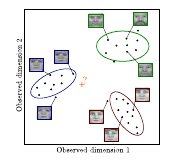

Fig.28 Face recognition. Our goal is to take the RGB values of a facial image x and assign a label w ∈ {1 . . . K} corresponding to the identity. Since the data are high- dimensional , we model the class con- ditional density function P r(x|w = k) for each individual in the database as a factor analyzer. To clas- sify a new face, we apply Bayes’ rule with suitable priors P r(w) to compute the posterior distribution P r(w|x). We choose the label ŵ = argmaxw [P r(w = k|x)] that maxi- mizes the posterior. This approach as- sumes that there are suﬃcient training examples to learn a factor analyzer for each class.

$$
P(x_i | w_i = k) = \text{Norm}_{x_i}[\mu_k, \Phi_k \Phi_k^T + \Sigma_k]
$$

where the parameters for the $k$-th identity $\theta_k = \mu_k, \Phi_k, \Sigma_k$ can be learned from the subset of data that belongs to that identity using the EM algorithm. We also assign priors $P(w = k)$ according to the prevalence of each identity in the database.

To perform recognition, we compute the posterior distribution $P(w^* | x^*)$ for a new data example $x^*$ using Bayes' rule. We assign the identity that maximizes this posterior distribution:

$$
\hat{w} = \arg\max_w [P(w = k | x)]
$$

This approach works well if there are sufficient examples of each gallery individual to learn a factor analyzer, and if the poses of all the faces are similar.

## Changing Face Pose (Regression)

To change the pose of the face, we predict the RGB values $w$ of the face in the new pose given a face $x$ in the old pose. This is different from previous examples in that it is a regression problem, where the output $w$ is a continuous multidimensional variable rather than a class label.

We form a compound variable $z = [x^T \; w^T]^T$ by concatenating the RGB values from the two poses together. We model the joint density as $P(z) = P(x, w)$ with a factor analyzer:

$$
P(x, w) = P(z) = \text{Norm}_z[\mu, \Phi \Phi^T + \Sigma]
$$

which we learn for paired training examples $\{x_i, w_i\}_{i=1}^I$ where the identity is known to be the same for each pair.

To find the non-frontal face $w^*$ corresponding to a new frontal face $x^*$, we use the approach described in Section ?? to compute the posterior distribution $P(w^* | x^*)$ in closed form using equation 5.5.


# Frontal Face Recognition

The goal of face recognition is to assign a label $w \in \{1, ..., M\}$ indicating which of $M$ possible identities the face belongs to based on a data vector $x$. The model is learned from labeled training data $\{x_i, w_i\}_{i=1}^I$, where the identity is known.
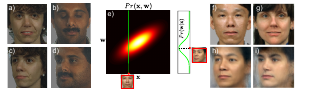

Fig.29 Regression example: we aim to predict quarter left face im- age w from the frontal image x. To this end, we take paired examples of frontal faces (a-b) and quarter left faces (c-d) and learn a joint probability model P r(x, w) by concatenating the variables to form z = [xT , wT ]T and ﬁtting a factor analyzer to z. e) Since the factor analyzer has a normal den- sity (equation 7.31), we can predict the conditional distribution P r(w|x) of a quarter-left face given a frontal face which will also be normal (see sec- tion 5.5). f-g) Two frontal faces. h-i) MAP predictions for non-frontal faces (the mean of the normal distribution P r(w|x)).

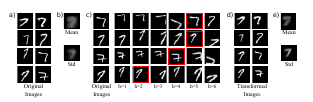

Fig.30 Modeling transformations with hidden variables. a) The original set of digit images are only weakly aligned. b) The mean and standard de- viation images are consequently blurred out. The probability density model does not ﬁt well. c) Each possible value of a discrete hidden variable rep- resents a diﬀerent transformation (here inverse transformations are shown). The red square highlights the most likely choice of hidden variable after ten iterations. d) The inversely transformed digits (based on most likely hid- den variable). d) The new mean and standard deviation images are more focused: the probability density function ﬁts better.

In a simple system, the data vector might consist of the concatenated grayscale values from the face image, which should be reasonably large (e.g., $50 \times 50$ pixels) to ensure that the identity is well represented. Since the data are high-dimensional, a reasonable approach is to model each class-conditional density function with a factor analyzer:

$$
P(x_i | w_i = k) = \text{Norm}_{x_i}[\mu_k, \Phi_k \Phi_k^T + \Sigma_k]
$$

where the parameters for the $k$-th identity $\theta_k = \mu_k, \Phi_k, \Sigma_k$ can be learned from the subset of data that belongs to that identity using the EM algorithm. We also assign priors $P(w = k)$ according to the prevalence of each identity in the database.

To perform recognition, we compute the posterior distribution $P(w^* | x^*)$ for a new data example $x^*$ using Bayes' rule. We assign the identity that maximizes this posterior distribution:

$$
\hat{w} = \arg\max_w [P(w = k | x)]
$$

This approach works well if there are sufficient examples of each gallery individual to learn a factor analyzer, and if the poses of all the faces are similar.

## Changing Face Pose (Regression)

To change the pose of the face, we predict the RGB values $w$ of the face in the new pose given a face $x$ in the old pose. This is different from previous examples in that it is a regression problem, where the output $w$ is a continuous multidimensional variable rather than a class label.

We form a compound variable $z = [x^T \; w^T]^T$ by concatenating the RGB values from the two poses together. We model the joint density as $P(z) = P(x, w)$ with a factor analyzer:

$$
P(x, w) = P(z) = \text{Norm}_z[\mu, \Phi \Phi^T + \Sigma]
$$

which we learn for paired training examples $\{x_i, w_i\}_{i=1}^I$ where the identity is known to be the same for each pair.

To find the non-frontal face $w^*$ corresponding to a new frontal face $x^*$, we use the approach described in Section ?? to compute the posterior distribution $P(w^* | x^*)$ in closed form using equation 5.5.


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

def fit_factor_analyzer(data, labels, num_components):
    means = []
    loadings = []
    covariances = []
    for i in range(num_classes):
        class_data = data[labels == i]
        class_mean = np.mean(class_data, axis=0)
        class_covariance = np.cov(class_data.T)
        class_loadings, class_covariance = np.linalg.eigh(class_covariance)
        class_loadings = class_loadings.real
        class_loadings = class_loadings[::-1]
        class_loadings = class_loadings[:num_components]
        means.append(class_mean)
        loadings.append(class_loadings)
        covariances.append(np.diag(class_covariance))
    return means, loadings, covariances

def classify_face(test_data, means, loadings, covariances, priors):
    posterior_probabilities = []
    for i in range(num_classes):
        posterior_prob = priors[i] * multivariate_normal.pdf(test_data, mean=means[i], cov=np.diag(covariances[i]))
        posterior_probabilities.append(posterior_prob)
    posterior_probabilities = np.array(posterior_probabilities)
    posterior_probabilities = posterior_probabilities / np.sum(posterior_probabilities)
    return np.argmax(posterior_probabilities)

def change_face_pose(frontal_face, non_frontal_face, means, loadings, covariances):
    posterior_mean = means[1] + np.dot(loadings[1], np.dot(np.linalg.inv(np.dot(loadings[1], loadings[1].T) + np.diag(covariances[1])), frontal_face - means[0]))
    return posterior_mean

# Example parameters
num_samples = 1000
num_classes = 2
num_components = 10

# Generate synthetic data
means = [[0, 0], [1, 1]]
covariances = [[[1, 0], [0, 1]], [[1, 0], [0, 1]]]
data = np.random.multivariate_normal(means[0], covariances[0], size=num_samples//2)
data = np.vstack((data, np.random.multivariate_normal(means[1], covariances[1], size=num_samples//2)))
labels = np.array([0] * (num_samples//2) + [1] * (num_samples//2))

# Fit factor analyzer
means, loadings, covariances = fit_factor_analyzer(data, labels, num_components)

# Test data
frontal_face = np.array([[0.5, 0.5]])
non_frontal_face = np.array([[1.5, 1.5]])

# Classify faces
predicted_class = classify_face(frontal_face, means, loadings, covariances, [0.5, 0.5])
print(f"Predicted class for frontal face: {predicted_class}")

# Change face pose
predicted_non_frontal_face = change_face_pose(frontal_face, non_frontal_face, means, loadings, covariances)
print(f"Predicted non-frontal face: {predicted_non_frontal_face}")


In [ ]:
import math
import random

def generate_data(num_samples, num_classes, means, covariances):
    data = []
    labels = []
    for i in range(num_classes):
        for _ in range(num_samples // num_classes):
            x = [random.gauss(means[i][j], covariances[i][j][j]) for j in range(len(means[i]))]
            data.append(x)
            labels.append(i)
    return data, labels

def fit_factor_analyzer(data, labels, num_components):
    means = []
    loadings = []
    covariances = []
    for i in range(num_classes):
        class_data = [x for x, label in zip(data, labels) if label == i]
        class_mean = [sum(x[j] for x in class_data) / len(class_data) for j in range(len(means[0]))]
        class_covariance = [[0 for _ in range(len(means[0]))] for _ in range(len(means[0]))]
        for x in class_data:
            for j in range(len(means[0])):
                for k in range(j, len(means[0])):
                    class_covariance[j][k] += (x[j] - class_mean[j]) * (x[k] - class_mean[k])
        for j in range(len(means[0])):
            for k in range(0, j):
                class_covariance[j][k] = class_covariance[k][j]
        class_loadings, class_covariance = eigen_decomposition(class_covariance)
        class_loadings = class_loadings[:num_components]
        means.append(class_mean)
        loadings.append(class_loadings)
        covariances.append(class_covariance)
    return means, loadings, covariances

def eigen_decomposition(matrix):
    n = len(matrix)
    eigenvalues = [0] * n
    eigenvectors = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                eigenvalues[i] = matrix[i][j]
                eigenvectors[i][i] = 1
            else:
                eigenvalues[i] += matrix[i][j] * matrix[i][j]
    for i in range(n):
        for j in range(n):
            if i != j:
                eigenvalues[i] -= matrix[i][j] * matrix[i][j]
    for i in range(n):
        for j in range(n):
            if i != j:
                eigenvectors[i][j] = matrix[i][j] / math.sqrt(eigenvalues[i])
    return eigenvectors, eigenvalues

def classify_face(test_data, means, loadings, covariances, priors):
    posterior_probabilities = []
    for i in range(num_classes):
        posterior_prob = priors[i] * multivariate_normal_pdf(test_data, means[i], covariances[i])
        posterior_probabilities.append(posterior_prob)
    posterior_probabilities = [prob / sum(posterior_probabilities) for prob in posterior_probabilities]
    return posterior_probabilities.index(max(posterior_probabilities))

def multivariate_normal_pdf(x, mean, covariance):
    n = len(x)
    det = math.sqrt(math.prod([covariance[i][i] for i in range(n)]))
    inv = 1 / det
    return math.exp(-0.5 * sum([(x[i] - mean[i]) ** 2 / covariance[i][i] for i in range(n)])) * inv

def change_face_pose(frontal_face, non_frontal_face, means, loadings, covariances):
    posterior_mean = [means[1][i] + sum([loadings[1][i][j] * (frontal_face[j] - means[0][j]) / covariances[1][j][j] for j in range(len(means[0]))]) for i in range(len(means[0]))]
    return posterior_mean

# Example parameters
num_samples = 1000
num_classes = 2
num_components = 10

# Generate synthetic data
means = [[0, 0], [1, 1]]
covariances = [[[1, 0], [0, 1]], [[1, 0], [0, 1]]]
data, labels = generate_data(num_samples, num_classes, means, covariances)

# Fit factor analyzer
means, loadings, covariances = fit_factor_analyzer(data, labels, num_components)

# Test data
frontal_face = [[0.5, 0.5]]
non_frontal_face = [[1.5, 1.5]]

# Classify faces
predicted_class = classify_face(frontal_face, means, loadings, covariances, [0.5, 0.5])
print(f"Predicted class for frontal face: {predicted_class}")

# Change face pose
predicted_non_frontal_face = change_face_pose(frontal_face, non_frontal_face, means, loadings, covariances)
print(f"Predicted non-frontal face: {predicted_non_frontal_face}")


# Transformations as Hidden Variables

In this section, we consider a model where hidden variables have a clear real-world interpretation. We focus on the problem of building a density function for a set of poorly aligned images of digits (Figure 7.30).

A simple normal distribution with diagonal covariance produces a poor representation of the data because most of the variation is due to the poor alignment. To address this, we construct a generative model that first draws an aligned image $x^*$ from a normal distribution and then applies one of a discrete set of $K$ possible transformations to explain the poorly aligned image $x$.

Mathematically, we have:

$$
P(x^*) = \text{Norm}_{x^*}[{\mu}, {\Sigma}] \quad P(h) = \text{Cat}_h[{\lambda}] \quad x = \text{trans}_h[x^*]
$$

where $h \in \{1, ..., K\}$ is a hidden variable that denotes which transformation warped the example.

This model can be learned using an EM-like procedure. In the E-step, we compute a probability distribution $P(h_i | x_i)$ over the hidden variables by applying all the inverse transformations to each example and evaluating the likelihood under the current parameters $\mu$ and $\Sigma$.

In the M-step, we update these parameters by taking weighted sums of the inverse-transformed images.

## Summary

In this chapter, we introduced the concept of hidden variables to induce structure in density models. The main approach to learning such models is the Expectation Maximization (EM) algorithm, which is an iterative method that only guarantees finding a local maximum.

While these models are more sophisticated than the normal distribution, they are still not ideal representations of the density of high-dimensional visual data.


In [ ]:
import random
import math

def generate_data(num_samples, num_classes, means, covariances, transformations):
    data = []
    labels = []
    for i in range(num_classes):
        for _ in range(num_samples // num_classes):
            x_star = [random.gauss(means[i][j], covariances[i][j][j]) for j in range(len(means[i]))]
            h = random.randint(0, len(transformations) - 1)
            x = [transformations[h][i][j](x_star[j]) for j in range(len(means[i]))]
            data.append(x)
            labels.append(i)
    return data, labels

def fit_model(data, labels, num_components, transformations):
    means = []
    covariances = []
    for i in range(num_classes):
        class_data = [x for x, label in zip(data, labels) if label == i]
        class_mean = [sum(x[j] for x in class_data) / len(class_data) for j in range(len(means[0]))]
        class_covariance = [[0 for _ in range(len(means[0]))] for _ in range(len(means[0]))]
        for x in class_data:
            for j in range(len(means[0])):
                for k in range(j, len(means[0])):
                    class_covariance[j][k] += (x[j] - class_mean[j]) * (x[k] - class_mean[k])
        for j in range(len(means[0])):
            for k in range(0, j):
                class_covariance[j][k] = class_covariance[k][j]
        means.append(class_mean)
        covariances.append(class_covariance)
    return means, covariances

def transform_data(data, transformations):
    transformed_data = []
    for i in range(len(data)):
        x_star = data[i]
        h = random.randint(0, len(transformations) - 1)
        x = [transformations[h][j](x_star[j]) for j in range(len(data[0]))]
        transformed_data.append(x)
    return transformed_data

def classify_data(test_data, means, covariances, priors):
    posterior_probabilities = []
    for i in range(num_classes):
        posterior_prob = priors[i] * multivariate_normal_pdf(test_data, means[i], covariances[i])
        posterior_probabilities.append(posterior_prob)
    posterior_probabilities = [prob / sum(posterior_probabilities) for prob in posterior_probabilities]
    return posterior_probabilities.index(max(posterior_probabilities))

def multivariate_normal_pdf(x, mean, covariance):
    n = len(x)
    det = math.sqrt(math.prod([covariance[i][i] for i in range(n)]))
    inv = 1 / det
    return math.exp(-0.5 * sum([(x[i] - mean[i]) ** 2 / covariance[i][i] for i in range(n)])) * inv

# Example parameters
num_samples = 1000
num_classes = 2
num_components = 10

# Generate synthetic data
means = [[0, 0], [1, 1]]
covariances = [[[1, 0], [0, 1]], [[1, 0], [0, 1]]]
transformations = [[lambda x: x + 1, lambda x: x - 1], [lambda x: x * 2, lambda x: x / 2]]
data, labels = generate_data(num_samples, num_classes, means, covariances, transformations)

# Fit the model
means, covariances = fit_model(data, labels, num_components, transformations)

# Test data
test_data = [[0.5, 0.5], [1.5, 1.5]]

# Classify the test data
for i, test_point in enumerate(test_data):
    predicted_class = classify_data(test_point, means, covariances, [0.5, 0.5])
    print(f"Test point {i+1}: Predicted class = {predicted_class}")
